# Trabajo Práctico 2: Redes Neuronales

Antes de comenzar, importaremos las dependencias necesarias

In [7]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss, mean_squared_error
from copy import deepcopy
import matplotlib.pyplot as plt

Ahora, crearemos la función sugerida en el enunciado, que entrena una red iterativamente cierta cantidad de veces, midiendo progresivamente el error conseguido en los conjuntos de entrenamiento, validación y testeo. Esta función trabaja tanto con clasificadores como regresores, y utiliza las métricas pedidas para cada caso.

In [8]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento. 
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):

     if (isinstance(red, MLPClassifier)):
          metric = zero_one_loss
     elif (isinstance(red, MLPRegressor)):
          metric = mean_squared_error

     best_red = None
     best_score = float('inf')
     error_train = []
     error_val = []
     error_test = []

     for i in range(evaluaciones):
          red.fit(X_train, y_train)
          error_train.append(metric(y_train, red.predict(X_train)))
          val = metric(y_val, red.predict(X_val))
          if val < best_score:
               best_score = val
               best_red = deepcopy(red)
          error_val.append(val)
          error_test.append(metric(y_test, red.predict(X_test)))

     return best_red, error_train, error_val, error_test

# Ejercicio 1

Comenzaremos incluyendo el código para generar el dataset de las espirales, el cual ya explicamos en el TP0

In [3]:
def rand_polar_in_unit_circle():
  return (np.sqrt(np.random.uniform()), 2 * np.pi * np.random.uniform())

def polar_to_cartesian(rho, theta):
  return { "x": rho * np.cos(theta), "y": rho * np.sin(theta) }

def spirals(n):
  def is_between_curves(r, t): # Función para comprobar si ciertas coordenadas polares corresponden a un punto dentro de la curva (Clase 0)
    result = False
    while not result and r > 0: # Como nuestros ángulos van hasta 2pi, hay que restar iterativamente una 'vuelta completa' para ver si el punto está en la curva
      result = (t / (4 * np.pi)) <= r and r < ((t + np.pi) / (4 * np.pi))
      r -= 0.5
    return result

  vals = []
  while len(vals) < n//2:
    x = rand_polar_in_unit_circle()
    if(is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 0})

  while len(vals) < n:
    x = rand_polar_in_unit_circle()
    if(not is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 1})

  df = pd.DataFrame(vals)
  df.Output = df["Output"].astype('category')
  return df.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

A continuación, entrenamos modelos con 2, 10, 20 y 40 neuronas en la capa intermedia respectivamente. Luego, graficamos para cada modelo sus predicciones sobre el conjunto de test.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.wa

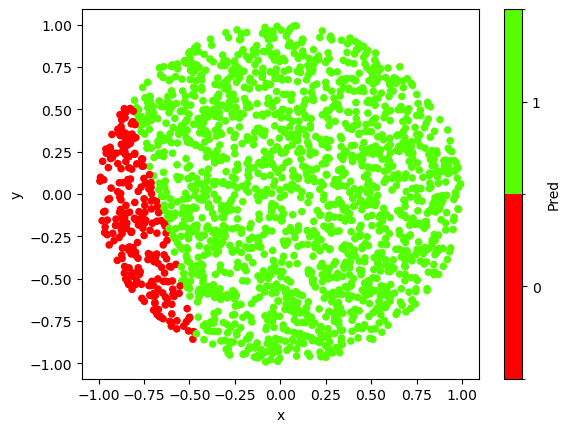

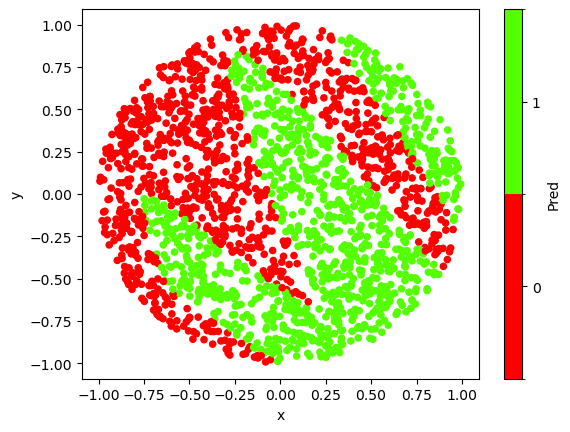

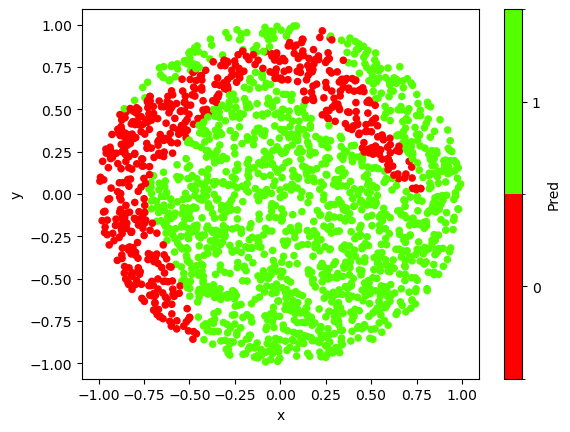

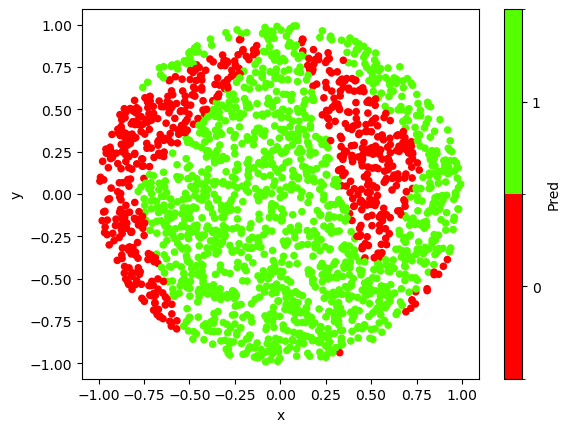

In [6]:
train_and_val = spirals(600)
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[["x", "y"]], train_and_val.Output, test_size=0.2)
test = spirals(2000)
X_test, y_test = test[["x", "y"]], test.Output
sizes = [2, 10, 20, 40]

for size in sizes:
  red = MLPClassifier(hidden_layer_sizes=(size,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=0.1, momentum=0.9, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
  red, e_train, e_val, e_test = entrenar_red(red, 1000, X_train, y_train, X_val, y_val, X_test, y_test)
  p = X_test.copy()
  p.insert(loc=2, column="Pred", value=red.predict(X_test))
  p.Pred = p.Pred.astype("category")
  p.plot.scatter(x="x", y="y", c="Pred", cmap="prism")


Como podemos ver en los gráficos, los resultados están lejos de ser ideales, aunque sí vemos indicios de que se está realizando un aprendizaje real de la clasificación, sobre todo cuando usamos más neuronas en la capa intermedia. Por ejemplo, todos los modelos, incluso los más pequeños, aprenden a clasificar en rojo la curva de la parte de abajo a la izquierda. Pruebas con conjuntos de entrenamiento más grandes nos muestran que efectivamente se logra un aprendizaje, con lo cual la razón por la que estos modelos no están aprendiendo la clasificación tan bien como podrían es por la escasez de los datos, o su poca representatividad de la distribución real.

Es interesante ver que, a diferencia de los modelos de árboles de decisión, estos modelos de perceptrones multicapa sí son capaces de aprender fronteras que no son rectas alineadas a los ejes de coordenadas.

Otra observación de interés es que al aumentar la cantidad de neuronas, en general se aprende una clasificación mejor ajustada a los datos, pero la diferencia entre los últimos dos gráficos (20 y 40 neuronas en la capa intermedia respectivamente) parece indicar que hay una disminución de ganancias a partir de cierto punto.

# Ejercicio 2

En este ejercicio trataremos de entrenar un modelo para clasificar el dataset `dos_elipses`. En este dataset, tenemos puntos en un cuadrado de lado $1$ centrado en $(0, 0)$, que dentro contiene dos elipses. Dentro de estas elipses, los puntos pertenecen a la clase $1$. Fuera de él, pertenecen a la clase $0$.

De manera similar al ejercicio anterior, entrenamos múltiples modelos, esta vez variando el `learning_rate` y el `momentum`. De cada uno, guardamos el mejor error conseguido en cada conjunto. Repetimos este proceso 10 veces y promediamos los mejores errores. Luego, comparamos los distintos promedios en una tabla.

In [15]:
train_and_val, test = (pd.read_csv("dos_elipses.data", header=None).sample(500), pd.read_csv("dos_elipses.test", header=None))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1]], train_and_val[2], test_size=0.2)
X_test, y_test = test[[0, 1]], test[2]

momentums = [0, 0.5, 0.9]
learning_rates = [0.1, 0.01, 0.001]

table = []

for learning_rate in learning_rates:
  for momentum in momentums:
    best_train = 0
    best_val = 0
    best_test = 0
    for i in range(10):
      red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=50)
      red, e_train, e_val, e_test = entrenar_red(red, 300, X_train, y_train, X_val, y_val, X_test, y_test)
      best_train += pd.Series(e_train).min()
      best_val += pd.Series(e_val).min()
      best_test += pd.Series(e_test).min()
    best_train /= 10
    best_val /= 10
    best_test /= 10
    table.append({"Learning Rate": learning_rate, "Momentum": momentum, "Training error": best_train, "Validation error": best_val, "Test error": best_test})

pd.DataFrame(table)

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.wa

,Learning Rate,Momentum,Training error,Validation error,Test error
0,0.100,0.0,0.15250,0.127,0.14595
1,0.100,0.5,0.05400,0.055,0.06015
2,0.100,0.9,0.04850,0.062,0.05930
3,0.010,0.0,0.24700,0.278,0.23865
4,0.010,0.5,0.20300,0.190,0.20345
5,0.010,0.9,0.10025,0.088,0.09655
6,0.001,0.0,0.25250,0.290,0.24350
7,0.001,0.5,0.25250,0.290,0.24350
8,0.001,0.9,0.23625,0.253,0.22885


Si comparamos los modelos entrenados sin momentum, podemos ver que el de learning rate más grande supera en desempeño a los otros dos, que tienen un rendimiento similar y bastante malo. Sin embargo, para el learning rate de $0.01$, esto se soluciona agregando momentum. Notamos una pequeña mejora con $0.5$, y una gran mejoría con $0.9$. En cambio, para el learning rate de $0.001$, el momentum no causa una diferencia significativa. Es posible que un learning rate tan pequeño no nos permita explorar casi nada del espacio de soluciones posibles, y nos lleve a mínimos locales correspondientes a clasificaciones triviales (por ejemplo, una gráfica realizada a modo de prueba con estos parámetros mostraba que el modelo aprendía a simplemente clasificar todos los puntos con la clase 0). Con learning rates más grandes, podemos evitar estos modelos triviales; y cuando no, podemos aumentar el momentum para que nos ayude a salir de ellos. Aún así, es importante saber que con learning rates grandes corremos el riesgo de pasar por alto caminos que nos llevarían a una solución más óptima. Sin embargo, este no parece ser el caso aquí, donde vemos que la mejor solución se consigue utilizando un learning rate de $0.1$ y un momentum de $0.9$.

A continuación entrenamos un modelo con estos parámetros y graficamos su error en los distintos conjuntos en función del número de épocas de entrenamiento.

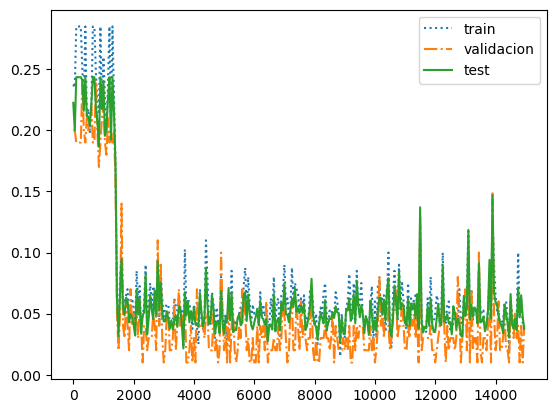

In [26]:
train_and_val, test = (pd.read_csv("dos_elipses.data", header=None).sample(500), pd.read_csv("dos_elipses.test", header=None))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1]], train_and_val[2], test_size=0.2)
X_test, y_test = test[[0, 1]], test[2]

red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=0.1, momentum=0.9, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=50)
red, e_train, e_val, e_test = entrenar_red(red, 300, X_train, y_train, X_val, y_val, X_test, y_test)
plt.plot([i*50 for i in range(300)],e_train,label="train",linestyle=":")
plt.plot([i*50 for i in range(300)],e_val,label="validacion",linestyle="-.")
plt.plot([i*50 for i in range(300)],e_test,label="test",linestyle="-")
plt.legend()
plt.show()

Vemos que por unas pocas épocas, nuestro modelo está en un mínimo local, pero una vez que encuentra el camino a una mejor solución el error baja notablemente y no vuelve a subir, salvo por cierto ruido estadístico. Además, no vemos mucha diferencia entre el desempeño en el conjunto de training y de test, por lo que no hay sobreajuste.

# Ejercicio 3

Ahora evaluaremos el impacto sobre nuestro modelo de las distintas formas de separar los conjuntos de entrenamiento y validación. Creamos modelos variando el split entre test y validación, y graficamos sus curvas de entrenamiento.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


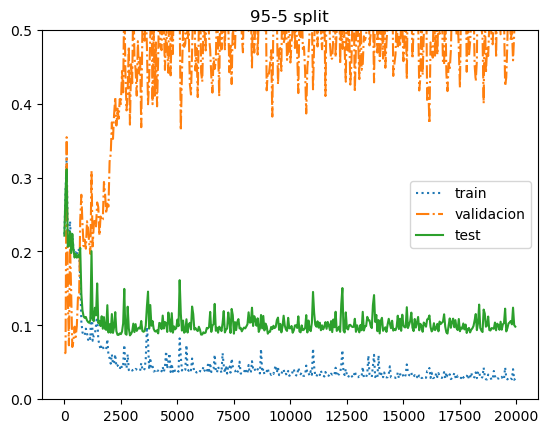

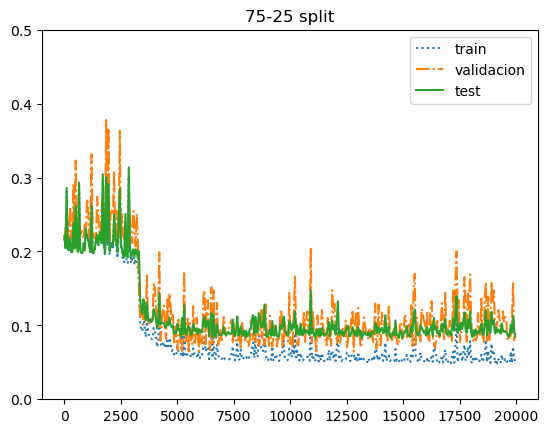

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


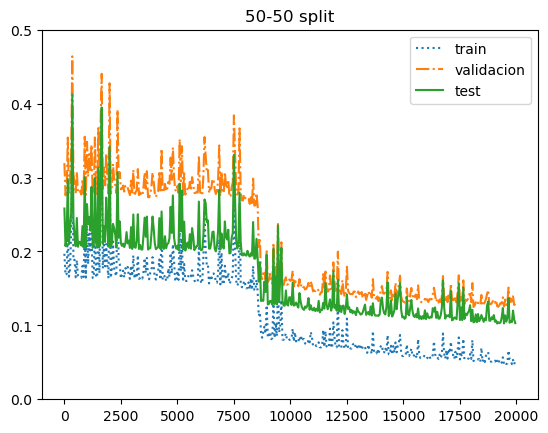

In [41]:
train_and_val, test = (pd.read_csv("ikeda.data", header=None, sep="\s+"), pd.read_csv("ikeda.test", header=None, sep="\s+").sample(2000))
X_test, y_test = test[[0, 1, 2, 3, 4]], test[5]
splits = [0.05, 0.25, 0.5]

for split in splits:
  red = MLPRegressor(hidden_layer_sizes=(30,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.9, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=50)
  X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1, 2, 3, 4]], train_and_val[5], test_size=split)
  red, e_train, e_val, e_test = entrenar_red(red, 400, X_train, y_train, X_val, y_val, X_test, y_test)
  plt.plot([i*50 for i in range(400)],e_train,label="train",linestyle=":")
  plt.plot([i*50 for i in range(400)],e_val,label="validacion",linestyle="-.")
  plt.plot([i*50 for i in range(400)],e_test,label="test",linestyle="-")
  plt.legend()
  plt.title(f"{int((1-split)*100)}-{int(split * 100)} split")
  plt.ylim(0, 0.5)
  plt.show()

En estos gráficos podemos ver claramente como, al tener más datos en el conjunto de validación, el error en este se asemeja cada vez más al error en el conjunto de test. Sin embargo, tambien vemos que al tener menos datos en el conjunto de entrenamiento, tardamos más en converger a una buena solución.

# Ejercicio 4

Reescribiremos la función `entrenar_red` para no usar un conjunto de validación, y devolver la suma de los valores al cuadrado de los pesos de la red en cada época.

In [3]:
def entrenar_red_sin_val(red, evaluaciones, X_train, y_train, X_test, y_test):

     if (isinstance(red, MLPClassifier)):
          metric = zero_one_loss
     elif (isinstance(red, MLPRegressor)):
          metric = mean_squared_error

     best_red = None
     best_score = float('inf')
     error_train = []
     weight_sum = []
     error_test = []

     for i in range(evaluaciones):
          red.fit(X_train, y_train)
          train = metric(y_train, red.predict(X_train))
          if train < best_score:
               best_score = train
               best_red = deepcopy(red)
          error_train.append(metric(y_train, red.predict(X_train)))
          weight_sum.append(sum(np.sum(np.square(w)) + np.sum(np.square(b)) for w, b in zip(red.coefs_, red.intercepts_)))
          error_test.append(metric(y_test, red.predict(X_test)))

     return best_red, error_train, weight_sum, error_test

A continuación, entrenaremos modelos variando el parámetro gamma. Graficamos el error en training y test para cada modelo, de manera que nos resulte más fácil comparar el desempeño.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


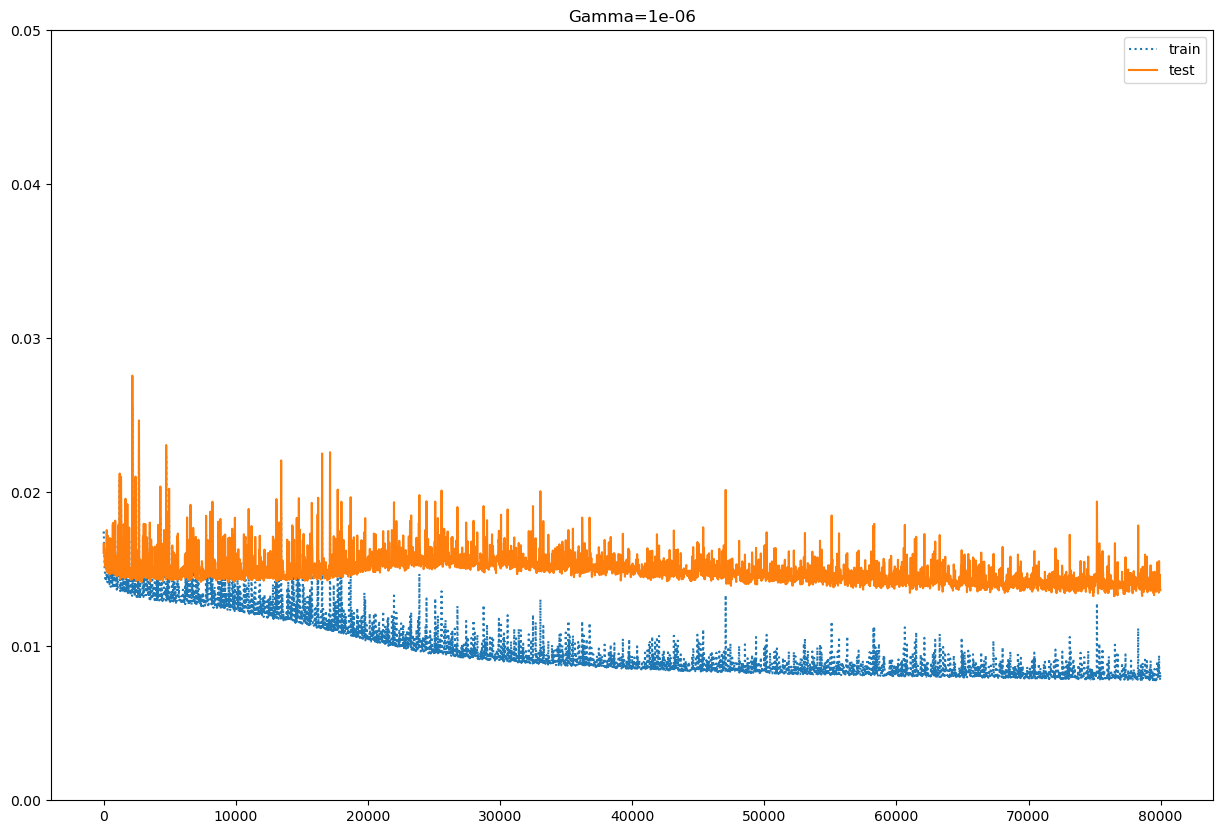

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


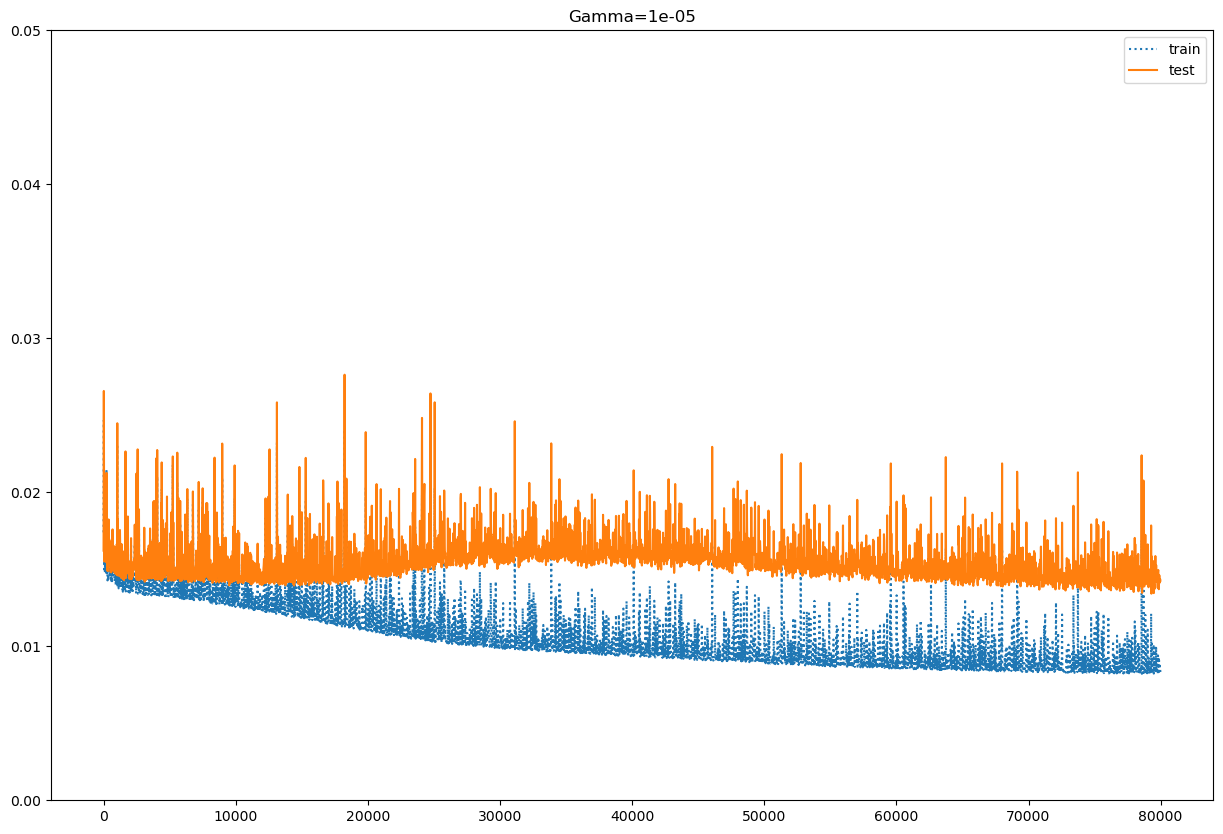

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


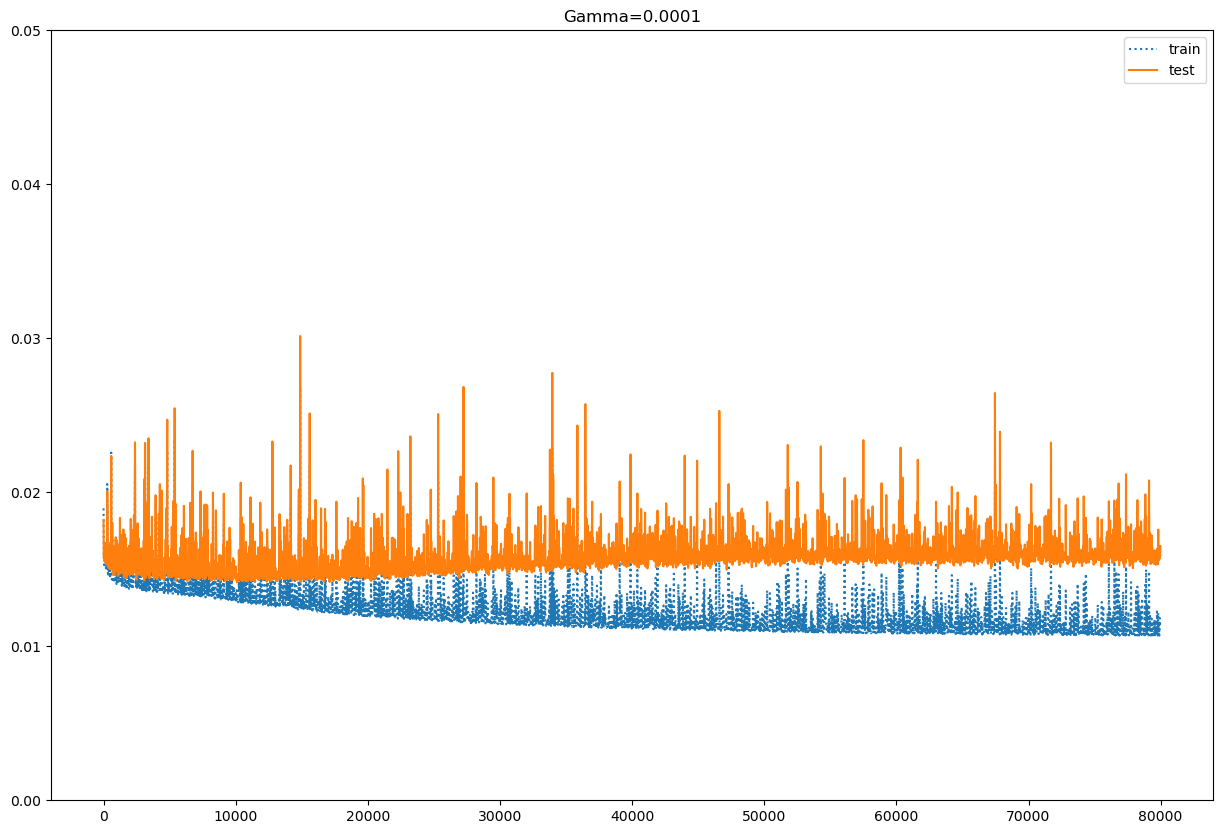

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


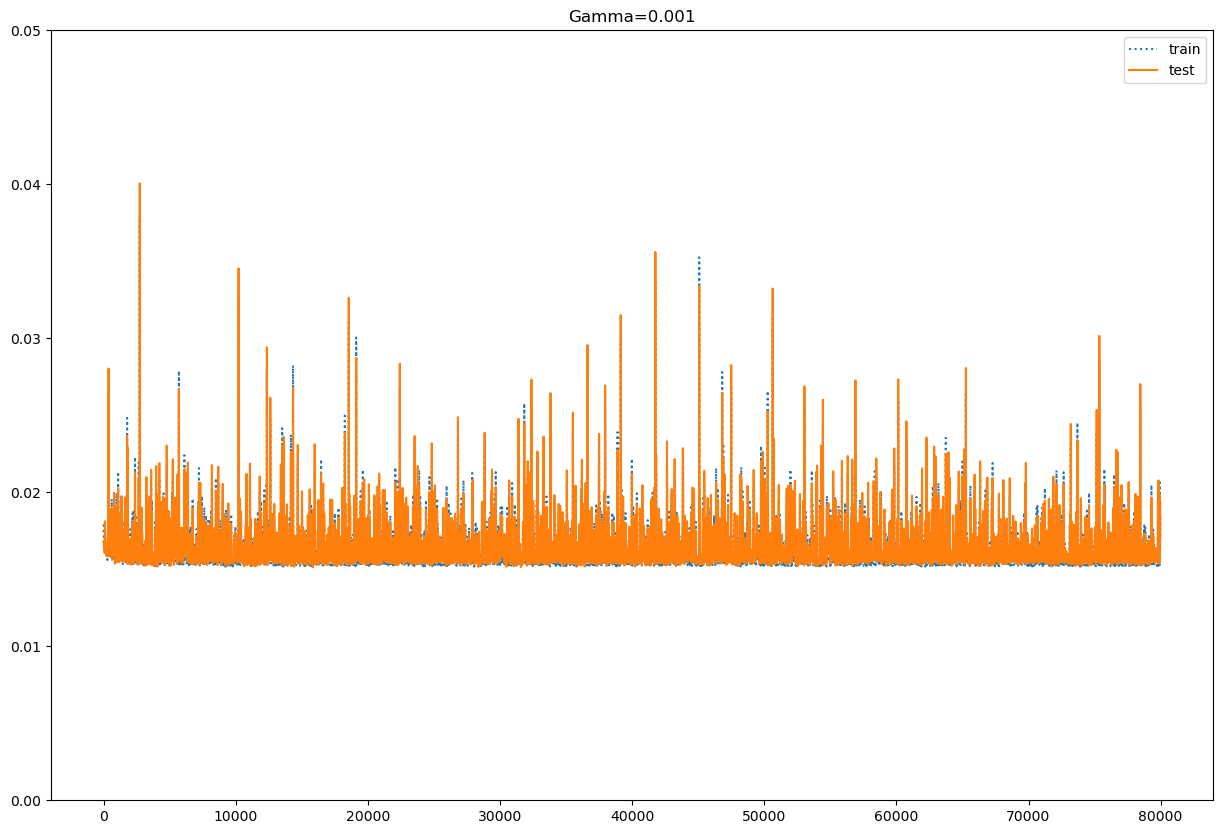

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


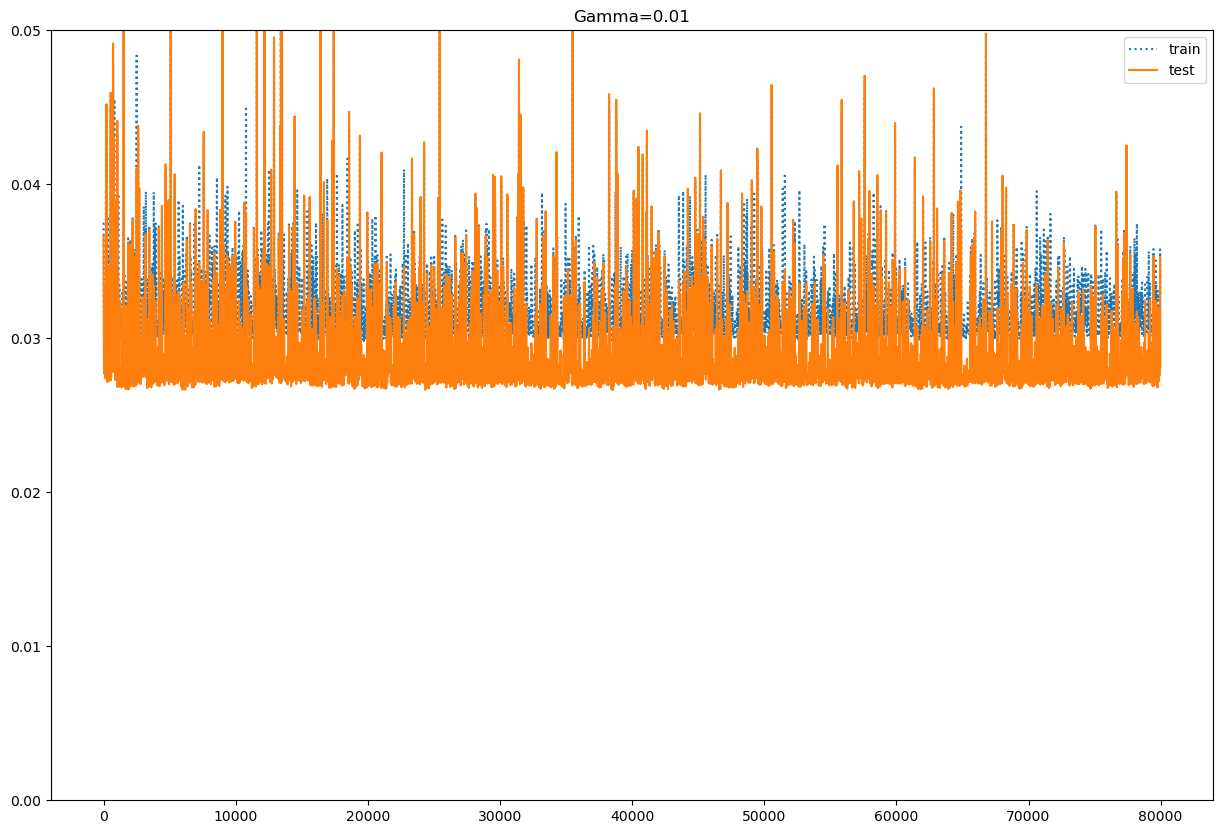

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


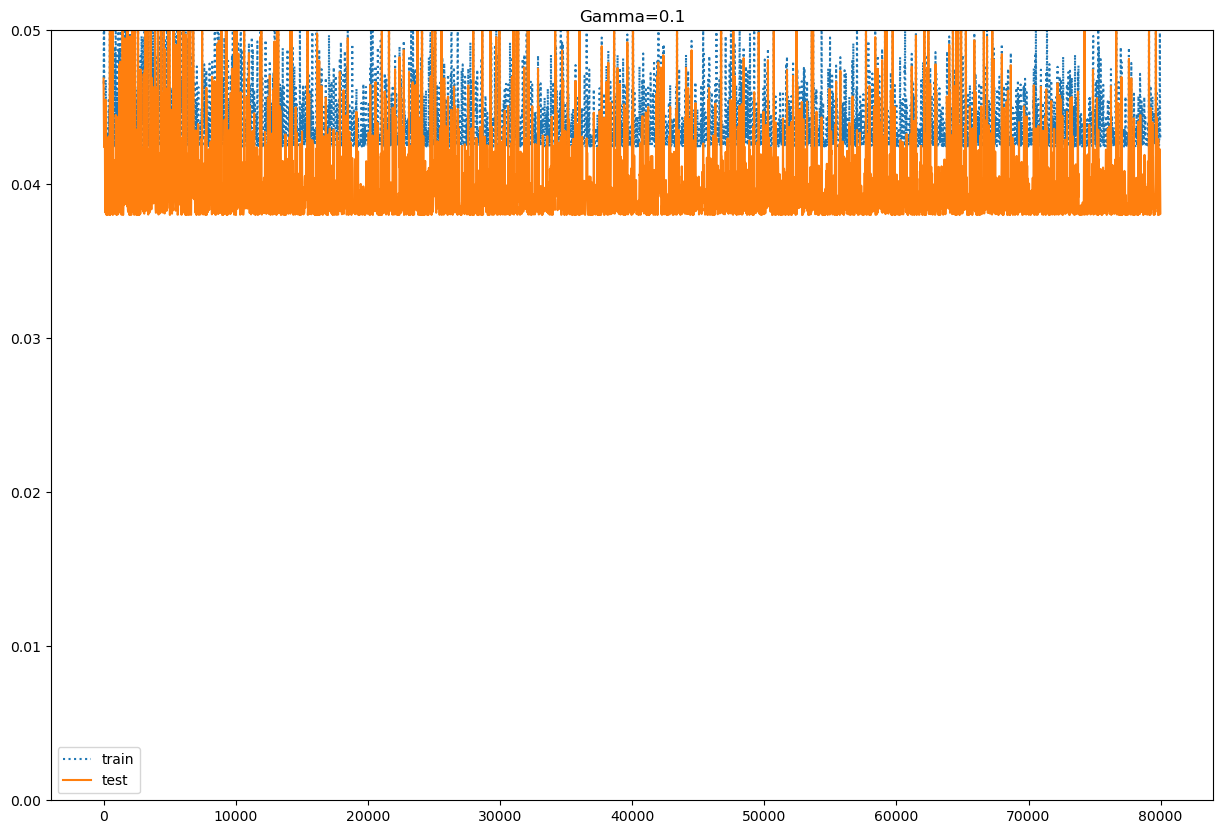

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


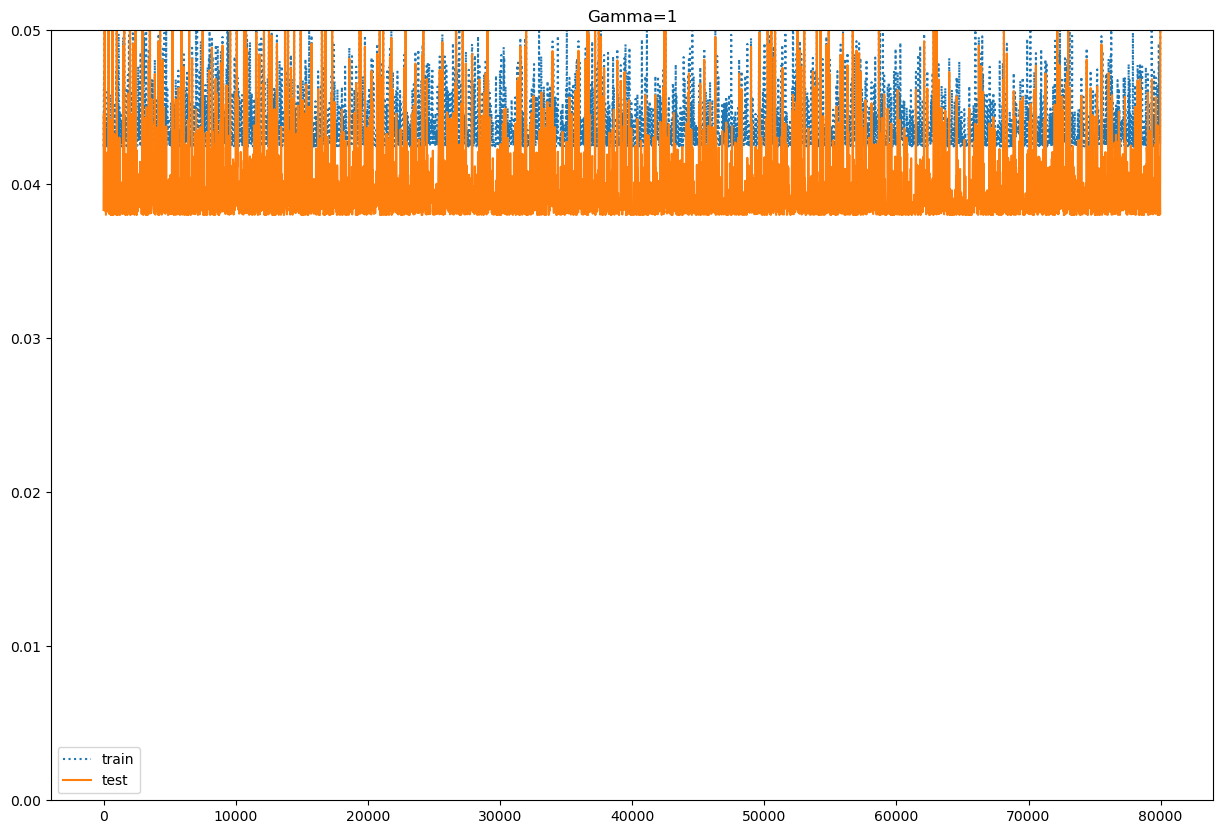

In [13]:
train, test = (pd.read_csv("ssp.data", header=None), pd.read_csv("ssp.test", header=None))
X_train, y_train = train[list(range(11))], train[12]
X_test, y_test = test[list(range(11))], test[12]
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

for gamma in gammas:
  red = MLPRegressor(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=0.05, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
  red, e_train, weight_sum, e_test = entrenar_red_sin_val(red, 4000, X_train, y_train, X_test, y_test)
  plt.figure(figsize=(15,10))
  plt.plot([i*20 for i in range(4000)],e_train,label="train",linestyle=":")
  plt.plot([i*20 for i in range(4000)],e_test,label="test",linestyle="-")
  plt.legend()
  plt.title(f"Gamma={gamma}")
  plt.ylim(0,)
  plt.show()

En estos gráficos se puede ver claramente el impacto de un mayor o menor valor para gamma.

En $10^{-6}$ vemos una diferencia de desempeño en training y test que se amplia a medida que entrenamos. Esta tendencia exhibe que se está produciendo sobreajuste. Para $10^{-5}$ y $10^{-4}$, vemos que la situación mejora progresivamente, y para $10^{-3}$ vemos que casi no hay sobreajuste, y todo esto manteniendo un desempeño casi igual de bueno en el conjunto de training.

Sin embargo, a medida que probamos valores de gamma más allá de estos, vemos otro fenómeno surgir. El desempeño en ambos conjuntos comienza a deteriorarse, posiblemente porque la penalización está teniendo un impacto demasiado grande sobre el aprendizaje de nuestro modelo, y no nos permite llegar a las soluciones más óptimas.

Es por esto que decidimos que el valor ideal en este caso es de $10^{-3}$. A continuación, entrenamos un modelo con $\gamma=10^{-6}$ y otro con $\gamma=10^{-3}$. Para cada uno graficamos el error y penalización a lo largo de las épocas de entrenamiento.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


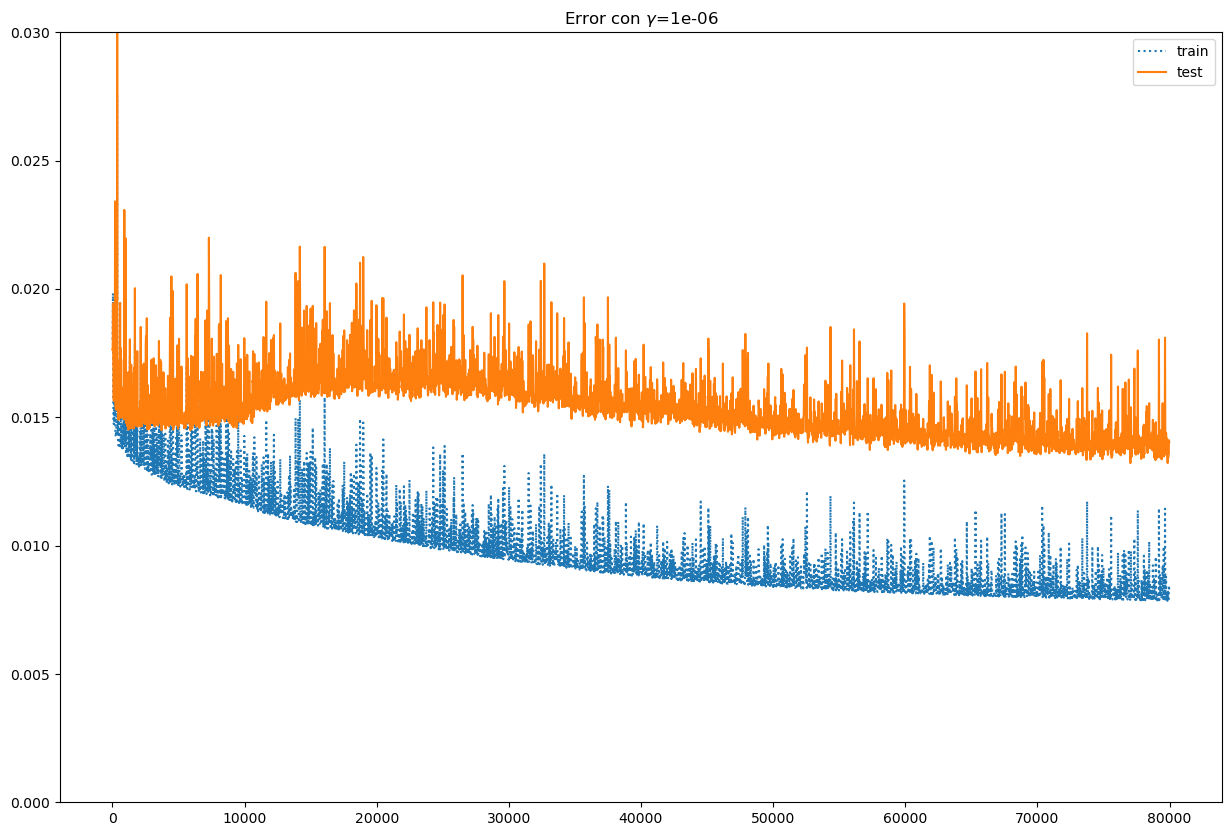

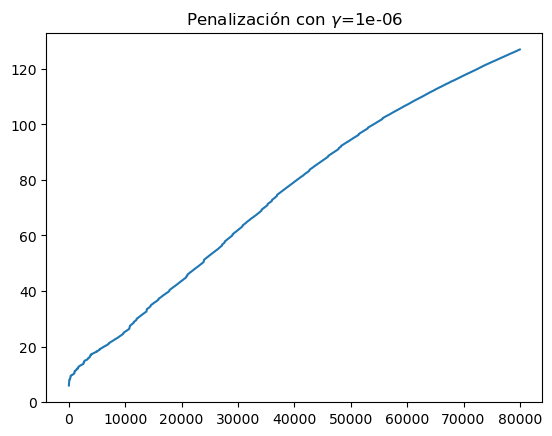

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


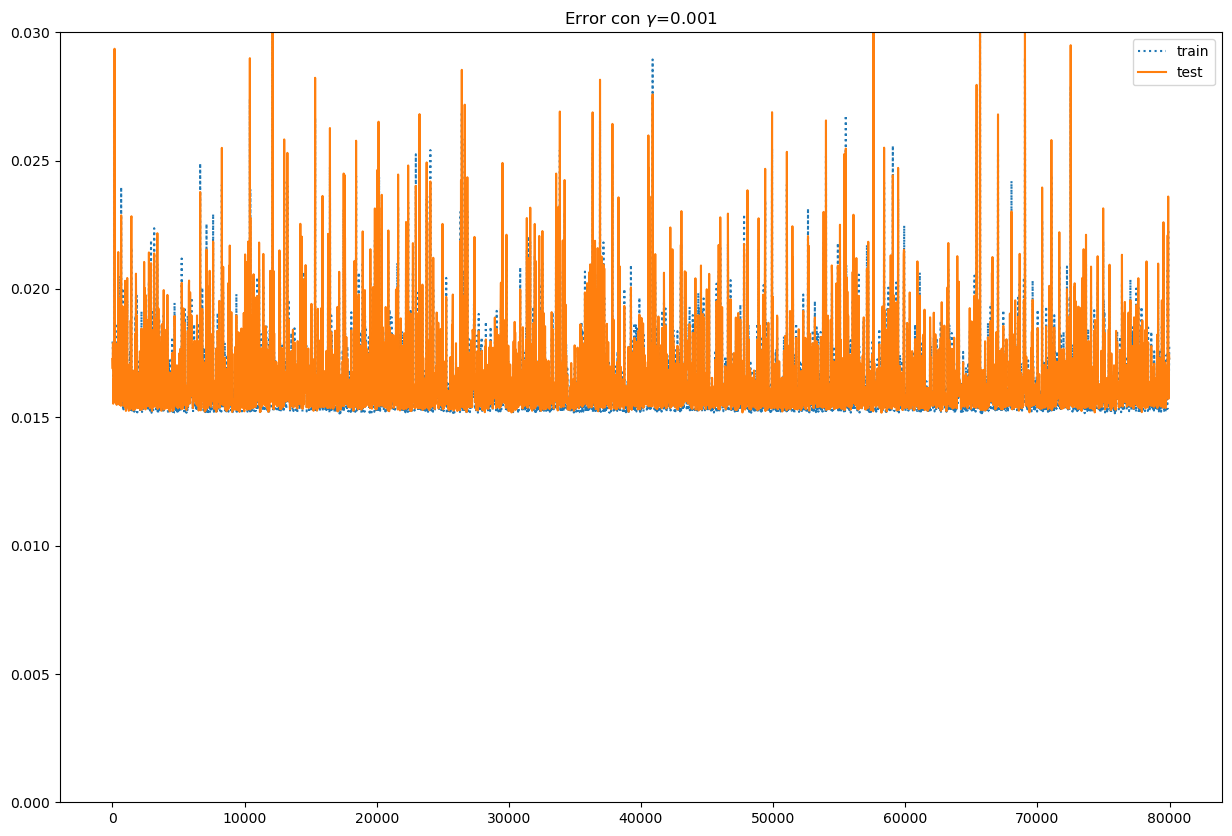

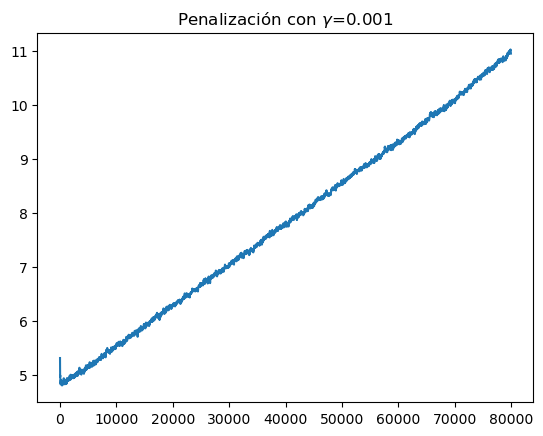

In [19]:
train, test = (pd.read_csv("ssp.data", header=None), pd.read_csv("ssp.test", header=None))
X_train, y_train = train[list(range(11))], train[12]
X_test, y_test = test[list(range(11))], test[12]
gammas = [0.000001, 0.001]

for gamma in gammas:
  red = MLPRegressor(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=0.05, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
  red, e_train, weight_sum, e_test = entrenar_red_sin_val(red, 4000, X_train, y_train, X_test, y_test)
  plt.figure(figsize=(15,10))
  plt.plot([i*20 for i in range(4000)],e_train,label="train",linestyle=":")
  plt.plot([i*20 for i in range(4000)],e_test,label="test",linestyle="-")
  plt.ylim(0, 0.03)
  plt.legend()
  plt.title(f"Error con $\gamma$={gamma}")
  plt.show()
  plt.plot([i*20 for i in range(4000)],weight_sum,linestyle="-")
  plt.title(f"Penalización con $\gamma$={gamma}")
  plt.show()

Como vemos, los resultados en cuanto al error en el conjunto de test son de hecho muy similares. La diferencia principal está en el tamaño de los pesos aprendidos por cada red. La red con un valor mayor de gamma logra una performance igual de buena, con menos diferencia entre training y test, con un modelo sin valores tan extremos.

# Ejercicio 5

Incluimos el código para generar los datasets, originalmente realizado para el TP0

In [5]:
def diagonal(d, n, C):
  df = pd.DataFrame(np.random.normal(-1, C * np.sqrt(d), (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en -1 cada una
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(1, C * np.sqrt(d), (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en 1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

def paralelo(d, n, C):
  v0 = [-1] + [0] * (d - 1)
  v1 = [1] + [0] * (d - 1)
  df = pd.DataFrame(np.random.normal(v0, [C] * d, (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en la componente correspondiente de v0
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(v1, [C] * d, (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en v1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

Luego, escribimos el código para comparar la performance de las redes y los árboles de decisión en ambos problemas. Para esto, modificamos el código que usamos en el TP anterior para el gráfico de los árboles. Para cada tamaño, en cada problema, entrenamos a la red 3 veces y promediamos el error, para obtener un mejor estimativo. Se podría repetir más veces, pero esto haría que el entrenamiento sea demasiado largo.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.wa

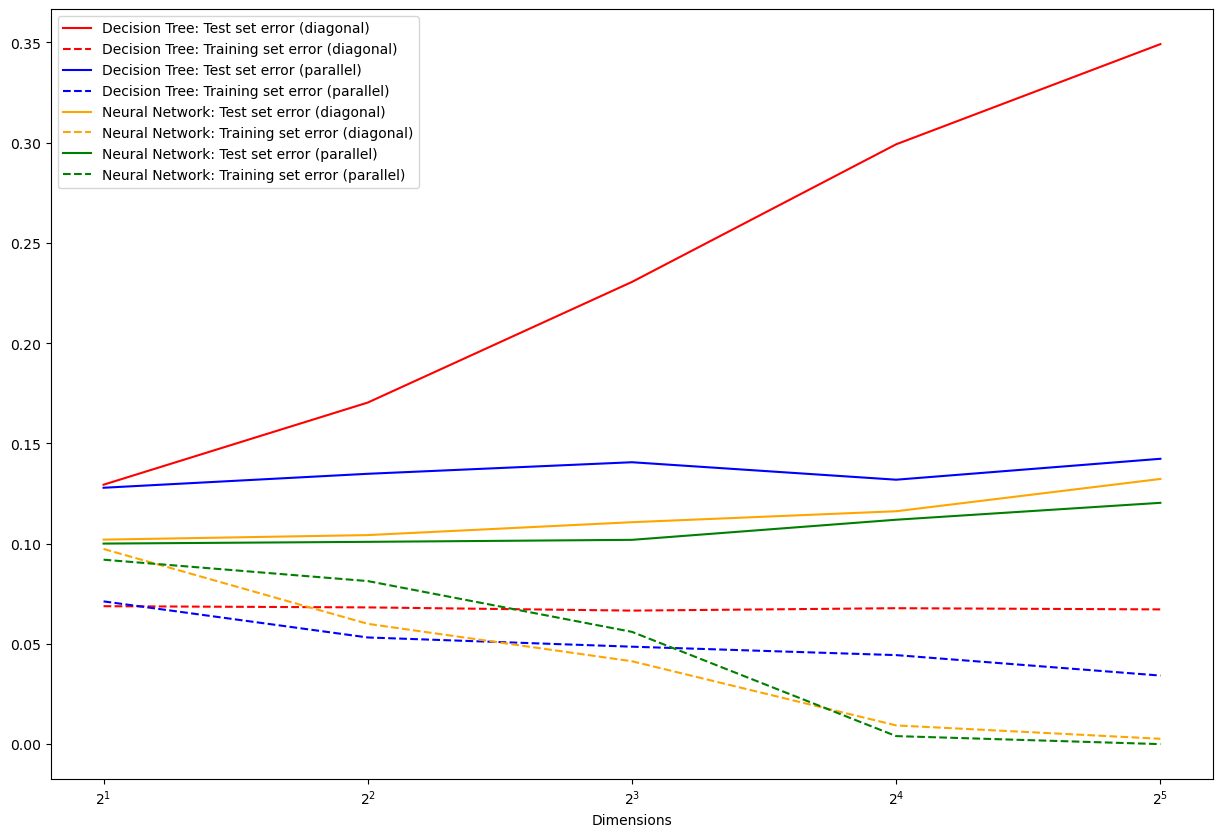

In [12]:
d_values = [2,4,8,16,32]

diag_stats = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(20):
    training_set = diagonal(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(0, d))], training_set["Output"])
    diag_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

parallel_stats = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(20):
    training_set = paralelo(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(d))], training_set["Output"])
    parallel_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

diag_stats = pd.DataFrame(diag_stats).groupby("Dimensions", as_index=False).mean()

parallel_stats = pd.DataFrame(parallel_stats).groupby("Dimensions", as_index=False).mean()

# ---Neural Networks---

diag_train_stats = []
diag_test_stats = []
for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  X_test, y_test = test_set[list(range(d))], test_set["Output"]
  best_train = 0
  best_test = 0
  for k in range(3):
    train_set = diagonal(d, 250, 0.78)
    X_train, y_train = train_set[list(range(d))], train_set["Output"]
    red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
    red, e_train, _, e_test = entrenar_red_sin_val(red, 300, X_train, y_train, X_test, y_test)
    best_train += pd.Series(e_train).min()
    best_test += pd.Series(e_test).min()
  best_train /= 3
  best_test /= 3
  diag_train_stats.append(best_train)
  diag_test_stats.append(best_test)

parallel_train_stats = []
parallel_test_stats = []
for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  X_test, y_test = test_set[list(range(d))], test_set["Output"]
  best_train = 0
  best_test = 0
  for k in range(3):
    train_set = paralelo(d, 250, 0.78)
    X_train, y_train = train_set[list(range(d))], train_set["Output"]
    red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
    red, e_train, _, e_test = entrenar_red_sin_val(red, 300, X_train, y_train, X_test, y_test)
    best_train += pd.Series(e_train).min()
    best_test += pd.Series(e_test).min()
  best_train /= 3
  best_test /= 3
  parallel_train_stats.append(best_train)
  parallel_test_stats.append(best_test)

# ---Neural Networks---

diag_ax = diag_stats.plot.line(x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="red", logx=True, figsize=(15, 10))
parallel_stats.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="blue", logx=True)
diag_ax.plot(d_values, diag_test_stats, color="orange", linestyle="-")
diag_ax.plot(d_values, diag_train_stats, color="orange", linestyle="--")
diag_ax.plot(d_values, parallel_test_stats, color="green", linestyle="-")
diag_ax.plot(d_values, parallel_train_stats, color="green", linestyle="--")
diag_ax.legend(labels=["Decision Tree: Test set error (diagonal)", "Decision Tree: Training set error (diagonal)", "Decision Tree: Test set error (parallel)", "Decision Tree: Training set error (parallel)", "Neural Network: Test set error (diagonal)", "Neural Network: Training set error (diagonal)", "Neural Network: Test set error (parallel)", "Neural Network: Training set error (parallel)"])
diag_ax.set_xscale("log", base=2)

Como podemos ver, las redes neuronales obtienen una mejor performance en el conjunto de test en ambos problemas e independientemente de la dimensionalidad. Más aún, en el problema diagonal las redes neuronales no parecen tener el problema de los árboles de decisión para dimensiones muy altas. Sin embargo, del gráfico también podemos observar que las redes neuronales amplían su diferencia entre training y test a medida que aumenta la dimensionalidad. Esto indica que está aumentando el sobreajuste, aunque en este caso su efecto sobre el desempeño en el conjunto de test no es tan grande.

# Ejercicio 6

Primero importamos el dataset iris

In [1]:
from sklearn.datasets import load_iris

Luego, separamos los datos en conjuntos de entrenamiento, validación y test. Hecho esto, entrenamos nuestro modelo y graficamos los resultados. Los parámetros elegidos fueron:

 - $\eta$ = 0.01
 - $\gamma$ = 0.001
 - $\alpha$ = 0.3
 - 20 neuronas en la capa intermedia
 - 300 evaluaciones de 20 épocas

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


0.0


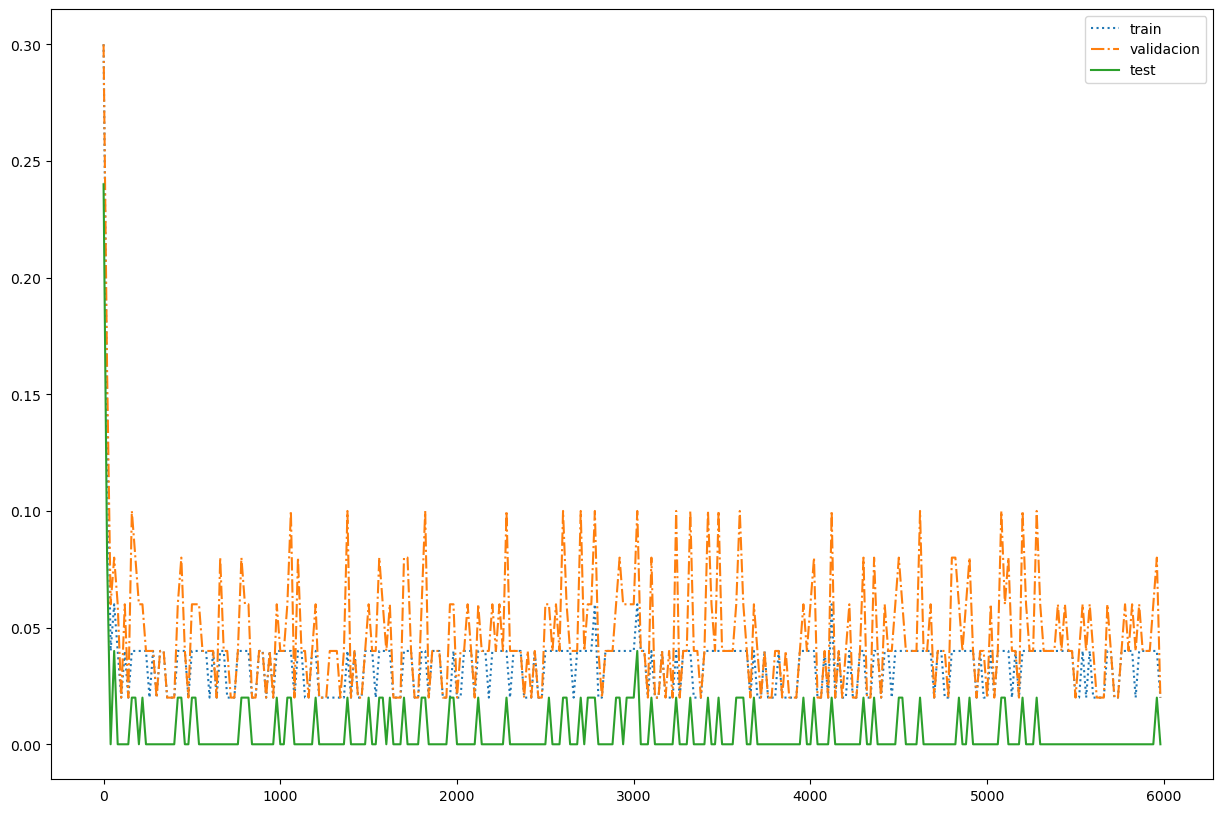

In [31]:
X, y = load_iris(as_frame=True, return_X_y=True)
X_train_and_val, X_test, y_train_and_val, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33)
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X_train_and_val, y_train_and_val, test_size=0.5)
red = MLPClassifier(hidden_layer_sizes=(20,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
red, e_train, e_val, e_test = entrenar_red(red, 300, X_train, y_train, X_val, y_val, X_test, y_test)
plt.figure(figsize=(15, 10))
plt.plot([i*20 for i in range(300)],e_train,label="train",linestyle=":")
plt.plot([i*20 for i in range(300)],e_val,label="validacion",linestyle="-.")
plt.plot([i*20 for i in range(300)],e_test,label="test",linestyle="-")
print(zero_one_loss(y_test, red.predict(X_test)))
plt.legend()
plt.show()

Como vemos, bastan con muy pocas épocas de entrenamiento para alcanzar un error prácticamente nulo en el conjunto de test. Esto es ampliamente superior al desempeño de los árboles de decisión en la misma tarea, el cual habíamos visto en el tp anterior.

Ahora evaluaremos el desempeño en el dataset _Faces_. Importamos el mismo y separamos conjuntos de training, validación y test.

In [37]:
train_and_val, test = pd.read_csv("faces.data", header=None), pd.read_csv("faces.test", header=None)

def normalize(df):
  return (df-df.min())/(df.max()-df.min())

X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(normalize(train_and_val[list(range(960))]), train_and_val[960], test_size=0.2)
X_test, y_test = normalize(test[list(range(960))]), test[960]

Hecho esto, entrenamos nuestro modelo y graficamos sus errores

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


0.10439560439560436


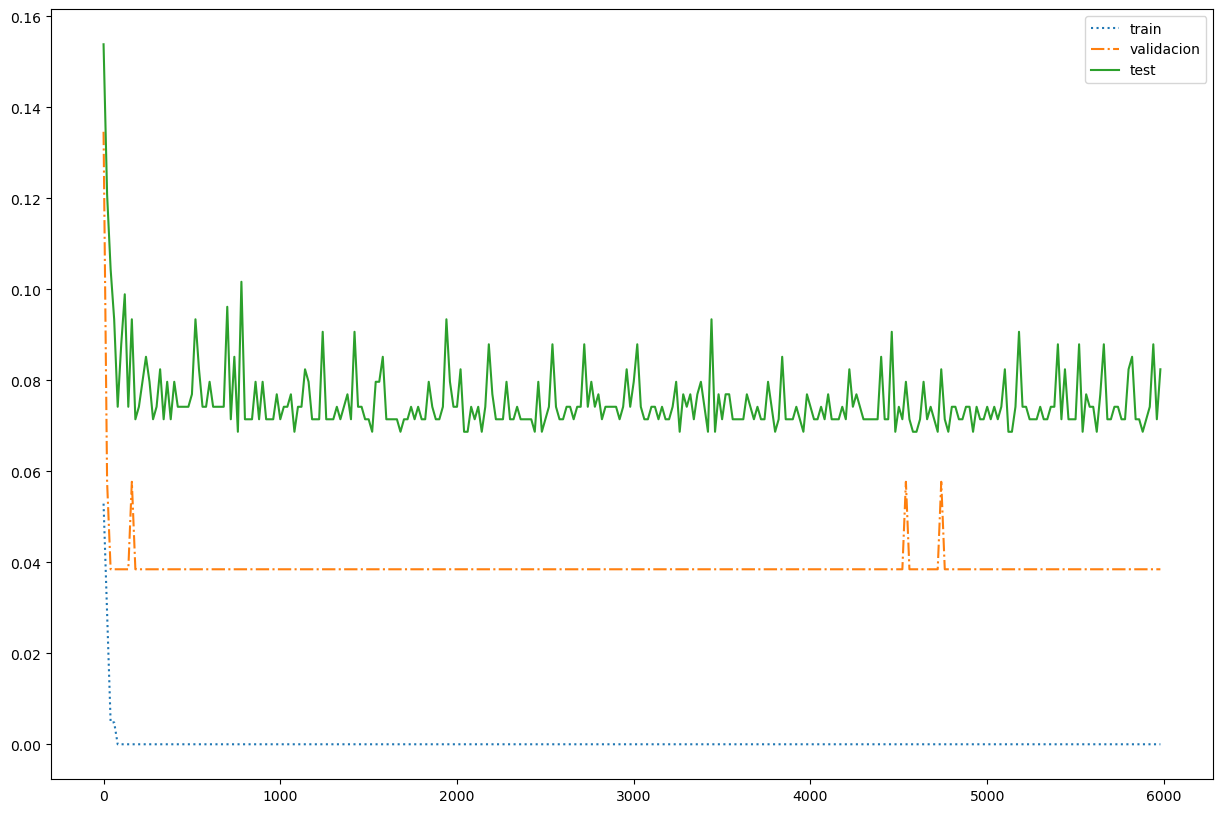

In [50]:
red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
red, e_train, e_val, e_test = entrenar_red(red, 300, X_train, y_train, X_val, y_val, X_test, y_test)
plt.figure(figsize=(15, 10))
plt.plot([i*20 for i in range(300)],e_train,label="train",linestyle=":")
plt.plot([i*20 for i in range(300)],e_val,label="validacion",linestyle="-.")
plt.plot([i*20 for i in range(300)],e_test,label="test",linestyle="-")
plt.legend()
plt.show()

Conseguimos un error de aproximadamente 0.08 para el conjunto de test. En los resultados que se muestran en el libro de Mitchell figura un error de 0.1. Nuestro mejor resultado puede atribuirse principalmente a una mayor cantidad de neuronas en la capa intermedia (nosotros usamos 6 vs las 3 de Mitchell), y a un learning rate más pequeño entrenado sobre mayor cantidad de épocas (Mitchell toma $\eta = 0.3$, nosotros usamos $\eta = 0.01$).

# Ejercicio 7

Evaluaremos ahora el impacto del uso de mini batches en el modelo. Igual que en los ejercicios anteriores, importamos el dataset, creamos los conjuntos necesarios, y entrenamos múltiples redes variando el parámetro `batch_size`. Para cada modelo entrenado, gráficamos el error en cada conjunto.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


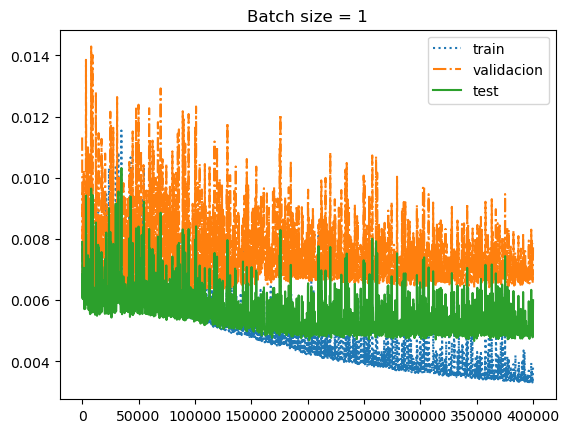

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


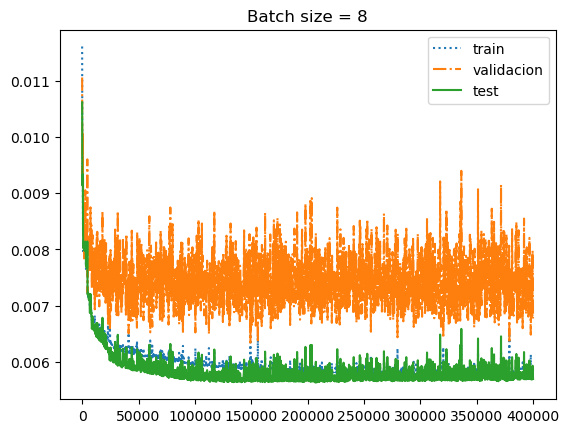

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


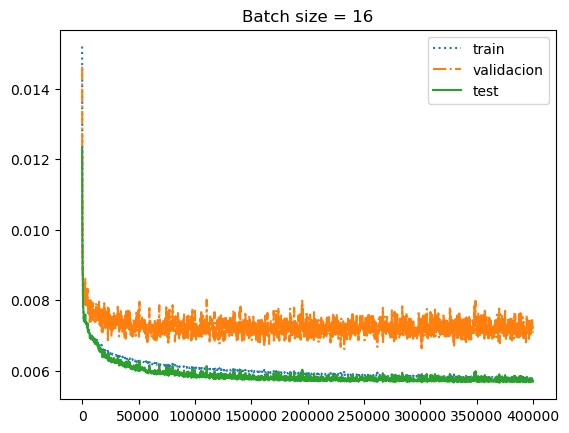

In [52]:
train_and_val, test = (pd.read_csv("ssp.data", header=None), pd.read_csv("ssp.test", header=None))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[list(range(12))], train_and_val[12], test_size=0.2)
X_test, y_test = test[list(range(12))], test[12]
batch_sizes = [1, 8, 16]

for batch_size in batch_sizes:
  red = MLPRegressor(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.0, batch_size=batch_size, learning_rate='constant', learning_rate_init=0.05, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=200)
  red, e_train, e_val, e_test = entrenar_red(red, 2000, X_train, y_train, X_val, y_val, X_test, y_test)
  plt.plot([i*200 for i in range(2000)],e_train,label="train",linestyle=":")
  plt.plot([i*200 for i in range(2000)],e_val,label="validacion",linestyle="-.")
  plt.plot([i*200 for i in range(2000)],e_test,label="test",linestyle="-")
  plt.legend()
  plt.title(f"Batch size = {batch_size}")
  plt.show()

Los gráficos muestran que al utilizar mini batches el modelo presenta menor sobreajuste que cuando no los utilizamos. Además, parece haber menos 'ruido' entre época y época.